# 1. Preprocessing & Load data

In [1]:
import os
import numpy as np
import cv2
import glob
from matplotlib import pyplot as plt
import sys
import seaborn as sns
import pandas as pd
import time

In [2]:
rootpath = "../Dataset"

## 1.1 Load the data and preprocessing

In [3]:
# Read in images from a filepath as graycsale
date = "2018-07-09-16-11-56_2018-07-09-16-51-40-823-"
imgL= cv2.imread(os.path.join(rootpath, date+"left.jpg"),cv2.IMREAD_GRAYSCALE)
imgR = cv2.imread(os.path.join(rootpath, date+"right.jpg"),cv2.IMREAD_GRAYSCALE)
imgTruth = cv2.imread(os.path.join(rootpath, date+"disparity.png"),cv2.IMREAD_GRAYSCALE)


Shape of imgL    :  (400, 881)
Shape of imgR    :  (400, 881)
Shape of imgTruth:  (400, 881)


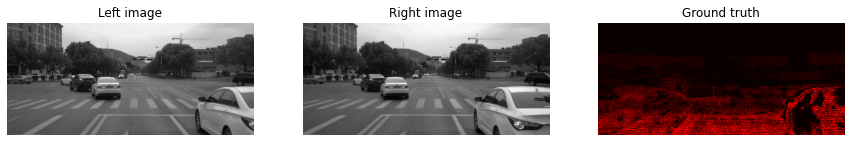

In [4]:
print("Shape of imgL    : ", imgL.shape)
print("Shape of imgR    : ", imgR.shape)
print("Shape of imgTruth: ", imgTruth.shape)

plt.subplots(figsize=(15, 15)) 

plt.subplot(1,3,1)
plt.imshow(imgL, cmap='gray')  
plt.title('Left image')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(imgR, cmap='gray')  
plt.title('Right image')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(imgTruth, cmap='hot')  
plt.title('Ground truth')
plt.axis('off')

plt.show()

## 1.2 Check for rectification 

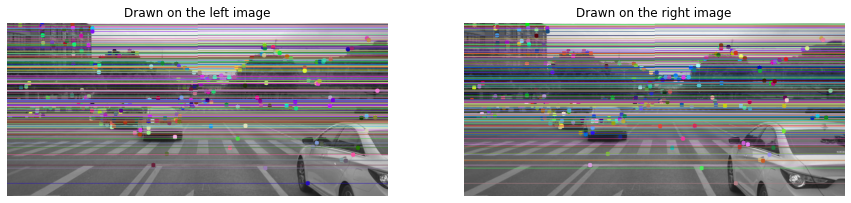

In [5]:
# Initiate SIFT detector
sift = cv2.SIFT_create() # if cv2 version >= 4.4.0 
# sift = cv2.xfeatures2d.SIFT_create() # if cv2 version = 4.3.x

# Compute SIFT keypoints and descriptors
kp1, des1 = sift.detectAndCompute(imgL, None)
kp2, des2 = sift.detectAndCompute(imgR, None)

# FLANN parameters and initialize
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Matching descriptor using KNN algorithm
matches = flann.knnMatch(des1, des2, k=2)

# Apply ratio test
ptsL = []
ptsR = []

for i,(m,n) in enumerate(matches):
    if m.distance < 0.8 *n.distance: # was 0.7
        ptsL.append(kp1[m.queryIdx].pt)
        ptsR.append(kp2[m.trainIdx].pt)

ptsL = np.int32(ptsL)
ptsR = np.int32(ptsR)


F, mask = cv2.findFundamentalMat(ptsL,ptsR,cv2.FM_LMEDS)

# Select only inlier points
ptsL = ptsL[mask.ravel()==1]
ptsR = ptsR[mask.ravel()==1]


# create a function to draw epilines over the images
# Epilines corresponding to the points in first image is drawn on second image
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color, 1)
        img1 = cv2.circle(img1, tuple(pt1), 5, color, -1)
        img2 = cv2.circle(img2, tuple(pt2), 5, color, -1)
    return img1,img2


# Find epilines corresponding to points in right image 
# and draw its lines on left image
linesL = cv2.computeCorrespondEpilines(ptsR.reshape(-1,1,2), 2, F)
linesL = linesL.reshape(-1,3)
img5, img6 = drawlines(imgL, imgR, linesL, ptsL, ptsR)

# Find epilines corresponding to points in left image 
# and draw its lines on right image
linesR = cv2.computeCorrespondEpilines(ptsL.reshape(-1,1,2), 1, F)
linesR = linesR.reshape(-1,3)
img3, img4 = drawlines(imgR, imgL, linesR, ptsR, ptsL)

# Display the results
plt.subplots(figsize=(15, 15)) 

plt.subplot(1,2,1)
plt.imshow(img5, cmap='gray')  
plt.title('Drawn on the left image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img3, cmap='gray')  
plt.title('Drawn on the right image')
plt.axis('off')

plt.show() 


- The epipolar lines are parallel and epipoles are met at infinity 
- No need for rectification

## 1.3 Get stereo depth map from cv2.StereoBM_create

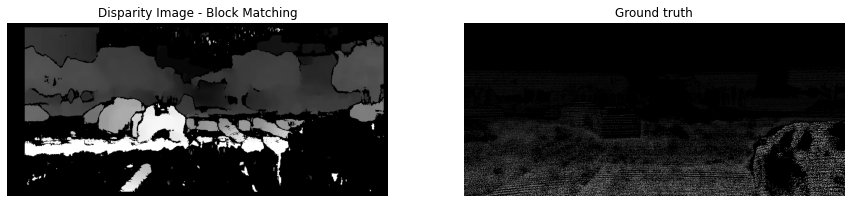

In [6]:
# Computing stereo correspondence using the block matching algorithm.
# Initialize the stereo block matching object 
''' numDisparities - the disparity search range. For each pixel algorithm will find 
                     the best disparity from 0 (default minimum disparity) to numDisparities. 
                     The search range can then be shifted by changing the minimum disparity.
    blockSize - the linear size of the blocks compared by the algorithm. 
                The size should be odd (as the block is centered at the current pixel). 
                Larger block size implies smoother, though less accurate disparity map. 
                Smaller block size gives more detailed disparity map, 
                but there is higher chance for algorithm to find a wrong correspondence. '''
num_disp = 32 # try to tune the parameters to get better&smooth result
block_size = 21
stereoBM = cv2.StereoBM_create(numDisparities=num_disp,
                             blockSize=block_size)

# Compute the disparity image
disparityBM = stereoBM.compute(imgL,imgR)

# Scale the pixel values to between 0-255 (Or you can normalized to [0,1])
min_val = disparityBM.min()
max_val = disparityBM.max()
disparityBM = ((disparityBM - min_val) / (max_val - min_val)*255).astype(np.uint8)


plt.subplots(figsize=(15, 15)) 

plt.subplot(1,2,1)
plt.imshow(disparityBM,'gray')
plt.title('Disparity Image - Block Matching')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(imgTruth, 'gray')  
plt.title('Ground truth')
plt.axis('off')

plt.show()

# 2. Calculate Local Correspondence

In [7]:
def rms_error(img, imgTruth=imgTruth):
    mask = imgTruth!=0
    return np.sqrt(np.sum(((img-imgTruth)**2)[mask])/np.sum(mask))

In [8]:
def fraction(img, truth, thres):
    mask = truth!=0
    return np.sum(np.logical_and(np.abs(img-truth)<thres, mask)/np.sum(mask))

In [9]:
#add the bolder with mean of image, with of boler = (window size-1)/2
def add_bolder(img,window_size):
    d =  int(window_size[0]/2)
    x,y = img.shape
    result = np.ones((x+2*d,y+2*d),np.float64)*np.mean(img)
    result[d:x+d,d:y+d] = img
    #print(result)
    return result

# triditional zncc without transformation
def zncc(imgL, imgR,window_size,D):
    # Get Width ,height
    h, w = imgL.shape
    d = window_size[0]
    bolder = int(d/2)

    # 2d array of scores
    score = np.empty((h-d, w-d))
    # to float
    imgL = np.array(imgL, dtype="float64")
    imgR = np.array(imgR, dtype="float64")
    
    imgL = add_bolder(imgL,window_size)
    imgR = add_bolder(imgR,window_size)
    
    bh,bw = imgL.shape
    
    # scan in left image
    best_ind = np.zeros((h,w))
    for dx in range(h+bolder, dajb):
        for dy in range(bolder, w+bolder):
            #get a block
            bL = imgL[dx-bolder:dx+bolder+1,dy-bolder:dy+bolder+1]
            # mean value of block
            mu_bL = np.mean(bL)
            # block - mean of block
            bL = bL - mu_bL
            
            best_ncc = 0
            best_dis = 0
            
            for ry in range(bolder, h+bolder-D):
                #right block
                bR = imgR[dx-bolder:dx+bolder+1, ry-bolder:ry+bolder+1]
                mu_bR = np.mean(bR)
                bR = bR-mu_bR
                # ZNCC
                stdL = np.std(bL)
                stdR = np.std(bR)
                result = np.sum(bL*bR)/(stdL*stdR*d*d)
                if result>best_ncc:
                    best_ncc = result
                    best_dis = abs(dy-ry)
                    print(best_dis)
            best_ind[dx-bolder,dy-bolder] = best_dis
    return best_ind
window_size = (15,15)
best_ind = zncc(imgL, imgR,window_size,D=150)

## 2.1 SAD, SSD, NCC and their variants

In [10]:
# apply the different bluring method to image
def filter_img(img, window_size, blur):
    if blur=="avg":
        return cv2.blur(img,window_size)
    if blur=="gau":
        return cv2.GaussianBlur(img,window_size,0)
    else:
        return cv2.medianBlur(np.uint8(img),window_size[0]).astype('float64')

In [11]:
# calculate the log disparity between two images give stereotype
def calculateLogDisp(stereoType, imgL, imgR, window_size, norm_std, blur):
    
    denominator = np.ones(imgL.shape, np.float64)
    
    
    # Calculate the numerator using formula
    if (stereoType=="SAD"):
        numerator = filter_img(np.abs(imgR-imgL),window_size, blur)
    elif (stereoType=="SSD"):
        numerator = filter_img((imgR-imgL)**2,window_size, blur)
    else:
        numerator = filter_img(np.abs(imgR*imgL),window_size, blur)
    
    # Calculate the denominator: normalizing terms
    if norm_std:
        denominator = filter_img(imgR**2,window_size, blur)
        
    
    # Calculate the log disparities
    if (stereoType=="SAD" or stereoType=="SSD"):
        best_log_disp = np.log(numerator+1e-10)-0.5*np.log(denominator+1e-10)
    else:
        best_log_disp = -1*(np.log(numerator+1e-10)-0.5*np.log(denominator+1e-10))
    
    return best_log_disp


In [12]:
# Find the disparity map with various options
def fastLocalStereo(stereoType, imgL, imgR, window_size, norm_mean=False, norm_std=False,blur="avg", D=100,  verbose=False):
    
    assert(imgL.shape==imgR.shape)
    
    # reassign data type allow for more accurate calculation
    imgL = imgL.astype('float64')
    imgR = imgR.astype('float64')
    
    
    
    numerator = np.ones(imgL.shape, np.float64)
    denominator = np.ones(imgL.shape, np.float64)
    
    
    # Normalizing the mean
    if norm_mean:
        imgL = imgL-cv2.blur(imgL, window_size)
        imgR = imgR-cv2.blur(imgR, window_size)
    
    
    # find the log disparity when d=0
    best_log_disp = calculateLogDisp(stereoType, imgL, imgR, window_size, norm_std, blur)
    best_ind = np.zeros(imgL.shape)
    
    
    prev_img = imgR
    
    # each time shift the imgR and using conv2d to get DSI and find disparity map
    for d in range(1, D):
        
        if (verbose and d%100==0):
            print("==finish {} iterations==".format(i))
        
        curr_img = np.hstack((prev_img[:,1:], prev_img[:,[0]])).astype('float64')
        
        
        curr_log_disp = calculateLogDisp(stereoType, imgL, curr_img, window_size, norm_std, blur)
        
        best_ind[curr_log_disp<best_log_disp] = d
        best_log_disp = np.minimum(best_log_disp, curr_log_disp)
        prev_img = curr_img
        
        if verbose:
            print('best_ind: ', best_ind)
            print('best_disp: ',best_log_disp)
    
    return best_ind
    
    

In [38]:
# def fastGlobalStereo(stereoType, imgL, imgR, window_size, norm_mean=False, norm_std=False, use_soft=False, D=200, verbose=False):
#     assert(imgL.shape==imgR.shape)
    
#     imgL = imgL.astype('float64')
#     imgR = imgR.astype('float64')
    
    
#     numerator = np.ones(imgL.shape, np.float64)
#     denominator = np.ones(imgL.shape, np.float64)
    
    
#     if norm_mean:
#         imgL = imgL-cv2.blur(imgL, window_size)
#         imgR = imgR-cv2.blur(imgR, window_size)
    
    
#     # best_log_disp = calculateLogDisp(stereoType, imgL, imgR, window_size, norm_std)
#     disparity_space = []
#     best_ind = np.zeros(imgL.shape)
    
    
#     prev_img = imgR
    
#     for d in range(D):
        
#         if (verbose and d%100==0):
#             print("==finish {} iterations==".format(d))
        
#         log_disp = calculateLogDisp(stereoType, imgL, prev_img, window_size, norm_std)
#         # log_disp = calculateDisp(stereoType, imgL, imgR, window_size, norm_std)
        
#         #print(log_disp)
#         disparity_space.append(np.expand_dims(log_disp, axis=-1))
        
#         next_img = np.hstack((prev_img[:,1:], prev_img[:,[0]])).astype('float64')
        
#         prev_img = next_img
        
#     disparity_space = np.concatenate(disparity_space,axis=-1)
    
#     # print(disparity_space[0,:,:])
#     # return intralineSearch(disparity_space,use_soft, stereoType!="NCC", True)
#     return np.argmin(disparity_space, axis=-1)
    
    
    
    

## 2.1.1 Tuning window size

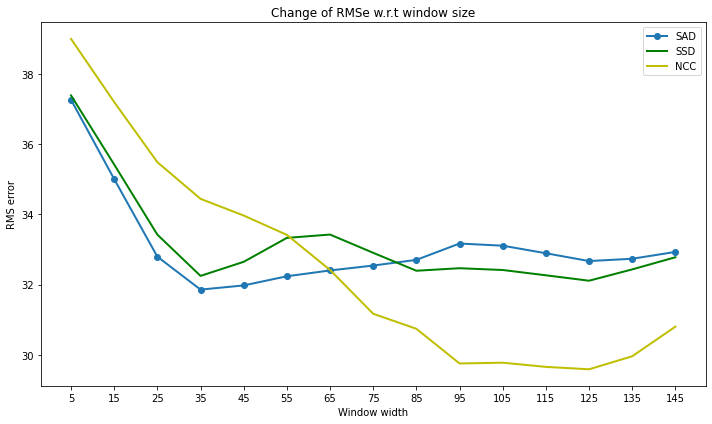

In [13]:
# Find best window size for each stereotype methods 
window_sizes = [5, 15, 25, 35, 45, 55, 65, 75, 85, 95,105,115, 125,135,145]
window_SAD = []
window_SSD = []
window_NCC = []


for k in window_sizes:
    #print("===============================")
    
    d_SAD = fastLocalStereo("SAD", imgL, imgR, (k,k),False, False)
    #print("size = ",k," d_SAD = ",rms_error(d_SAD))
    window_SAD.append(rms_error(d_SAD))
    

    d_SSD = fastLocalStereo("SSD", imgL, imgR, (k,k), False, False)
    #print("size = ",k," d_SSD = ",rms_error(d_SSD))
    window_SSD.append(rms_error(d_SSD))

    d_NCC = fastLocalStereo("NCC", imgL, imgR, (k,k), False, True)
    #print("size = ",k," d_NCC = ",rms_error(d_NCC))
    window_NCC.append(rms_error(d_NCC))

    
    
plt.figure(figsize=(10,6), tight_layout=True)

xs = [x for x in range(len(window_sizes))]

# Plotting
plt.plot(window_SAD, 'o-', linewidth=2, label = "SAD")
plt.plot(window_SSD, 'g-', linewidth=2, label = "SSD")
plt.plot(window_NCC, 'y-', linewidth=2, label = "NCC")

plt.xticks(xs, window_sizes)
plt.xlabel('Window width')
plt.ylabel('RMS error')
plt.title('Change of RMSe w.r.t window size')
plt.legend()

plt.savefig('saved_plots/window_width.jpg')
plt.show()

    
    

## 2.1.2 Tuning weight by changing kernel type

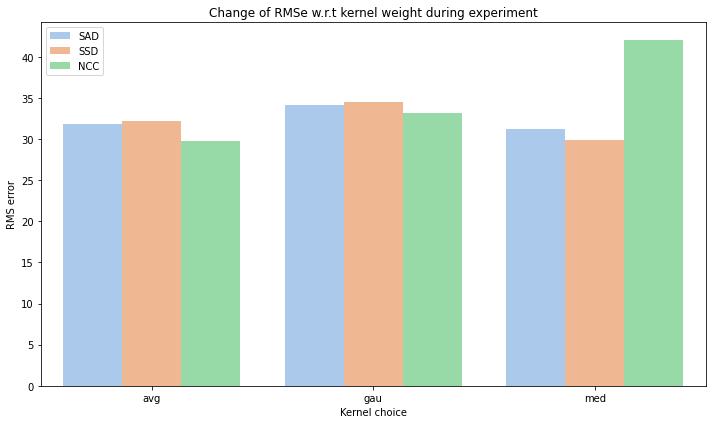

In [14]:
# Find the weight of matching block by changing the kernel type
blurs = ["avg", "gau","med"]
lst= [] 
weights_SAD = []
weights_SSD = []
weights_NCC = []
for b in blurs:
    #print("===============================")
    
    k=35
    d_SAD = fastLocalStereo("SAD", imgL, imgR, (k,k),False, False, b)
    #print("size = ",k," d_SAD = ",rms_error(d_SAD))
    #weights_SAD.append(rms_error(d_SAD))
    lst.append([rms_error(d_SAD), "SAD", b])
    

    d_SSD = fastLocalStereo("SSD", imgL, imgR, (k,k), False, False, b)
    #print("size = ",k," d_SSD = ",rms_error(d_SSD))
    #weights_SSD.append(rms_error(d_SSD))
    lst.append([rms_error(d_SSD), "SSD", b])

    k_n=95
    d_NCC = fastLocalStereo("NCC", imgL, imgR, (k_n,k_n), False, True, b)
    #print("size = ",k_n," d_NCC = ",rms_error(d_NCC))
    #weights_NCC.append(rms_error(d_NCC))
    lst.append([rms_error(d_NCC), "NCC", b])
    
    
    

df = pd.DataFrame(lst)
df.columns = ["val", "model", "kernel"]


plt.figure(figsize=(10, 6), tight_layout=True)

ax = sns.barplot(x=df['kernel'], y=df['val'], hue=df['model'], palette='pastel')
ax.set(title='Change of RMSe w.r.t kernel weight during experiment' ,xlabel='Kernel choice', ylabel='RMS error')
ax.legend( title_fontsize='12', loc='upper left')
# plt.savefig('saved_plots/weights.jpg')
# plt.savefig('saved_plots/weights.png')
plt.show()

## 2.1.3 Tuning the kernel type after the experiment

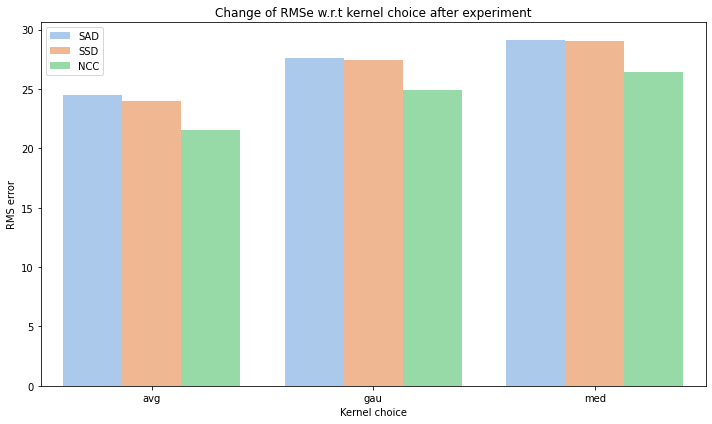

In [15]:
# Smooth the disparity map using various kernel options to get subpixel accuracy
blurs = ["avg", "gau","med"]
lst= [] 

weights_SAD = []
weights_SSD = []
weights_NCC = []
for b in blurs:
    #print("===============================")
    
    k=35
    d_SAD = filter_img(fastLocalStereo("SAD", imgL, imgR, (k,k),False, False), (k,k), b)
    #print("size = ",k," d_SAD = ",rms_error(d_SAD))
    lst.append([rms_error(d_SAD), "SAD", b])
    

    d_SSD = filter_img(fastLocalStereo("SSD", imgL, imgR, (k,k), False, False), (k,k), b)
    #print("size = ",k," d_SSD = ",rms_error(d_SSD))
    lst.append([rms_error(d_SSD), "SSD", b])

    k_n=95
    d_NCC = filter_img(fastLocalStereo("NCC", imgL, imgR, (k_n,k_n), False, True), (k_n,k_n), b)
    #print("size = ",k_n," d_NCC = ",rms_error(d_NCC))
    lst.append([rms_error(d_NCC), "NCC", b])
    
    
    

    
df = pd.DataFrame(lst)
#df = df.transpose()
df.columns = ["val", "model", "kernel"]

plt.figure(figsize=(10, 6), tight_layout=True)

ax = sns.barplot(x=df['kernel'], y=df['val'], hue=df['model'], palette='pastel')
ax.set(title='Change of RMSe w.r.t kernel choice after experiment' ,xlabel='Kernel choice', ylabel='RMS error')
ax.legend( title_fontsize='12', loc='upper left')
# plt.savefig('saved_plots/subpixel.jpg')
# plt.savefig('saved_plots/subpixel.png')
plt.show()

# 3. Results

In [33]:
dates = ["2018-07-09-16-11-56_2018-07-09-16-11-56-702-"]
#         "2018-07-09-16-11-56_2018-07-09-16-13-38-366-",
#         "2018-07-09-16-11-56_2018-07-09-16-14-54-205-",
#         "2018-07-09-16-11-56_2018-07-09-16-16-13-272-",
#         "2018-07-09-16-11-56_2018-07-09-16-25-10-570-",
#         "2018-07-09-16-11-56_2018-07-09-16-26-00-067-",
#         "2018-07-09-16-11-56_2018-07-09-16-27-53-156-",
#         "2018-07-09-16-11-56_2018-07-09-16-29-12-297-",
#         "2018-07-09-16-11-56_2018-07-09-16-29-56-824-",
#         "2018-07-09-16-11-56_2018-07-09-16-30-47-660-"]

thres = [4, 2, 1, 0.5, 0.25]

In [37]:
res_SAD = []
res_ZSAD = []
res_SSD = []
res_ZSSD = []
res_NCC = []
res_ZNCC = []

frac_4_SAD = []
frac_4_ZSAD = []
frac_4_SSD = []
frac_4_ZSSD = []
frac_4_NCC = []
frac_4_ZNCC = []

frac_2_SAD = []
frac_2_ZSAD = []
frac_2_SSD = []
frac_2_ZSSD = []
frac_2_NCC = []
frac_2_ZNCC = []

frac_1_SAD = []
frac_1_ZSAD = []
frac_1_SSD = []
frac_1_ZSSD = []
frac_1_NCC = []
frac_1_ZNCC = []

frac_0_5_SAD = []
frac_0_5_ZSAD = []
frac_0_5_SSD = []
frac_0_5_ZSSD = []
frac_0_5_NCC = []
frac_0_5_ZNCC = []

frac_0_25_SAD = []
frac_0_25_ZSAD = []
frac_0_25_SSD = []
frac_0_25_ZSSD = []
frac_0_25_NCC = []
frac_0_25_ZNCC = []


time_SAD = []
time_ZSAD = []
time_SSD = []
time_ZSSD = []
time_NCC = []
time_ZNCC = []



for date in dates:
    print("=========================================================")
    imgL= cv2.imread(os.path.join(rootpath, date+"left.jpg"),cv2.IMREAD_GRAYSCALE)
    imgR = cv2.imread(os.path.join(rootpath, date+"right.jpg"),cv2.IMREAD_GRAYSCALE)
    imgTruth = cv2.imread(os.path.join(rootpath, date+"disparity.png"),cv2.IMREAD_GRAYSCALE)

    
    k=35
    k_n=95
    
    
    start_time = time.time()
    d_SAD = filter_img(fastLocalStereo("SAD", imgL, imgR, (k,k),False, False), (k_n,k_n), "avg")
    time_SAD.append(time.time()-start_time)
    
    frac_4_SAD.append(fraction(d_SAD, imgTruth,4))
    frac_2_SAD.append(fraction(d_SAD, imgTruth,2))
    frac_1_SAD.append(fraction(d_SAD, imgTruth,1))
    frac_0_5_SAD.append(fraction(d_SAD, imgTruth,0.5))
    frac_0_25_SAD.append(fraction(d_SAD, imgTruth,0.25))
    
    res_SAD.append(rms_error(d_SAD, imgTruth))
    
    
    print("size = ",k," d_SAD = ",rms_error(d_SAD,imgTruth))
    
    
    
    
    
    
    start_time = time.time()
    d_ZSAD = filter_img(fastLocalStereo("SAD", imgL, imgR, (k,k),True, True), (k_n,k_n), "avg")
    time_ZSAD.append(time.time()-start_time)
    
    frac_4_ZSAD.append(fraction(d_ZSAD, imgTruth,4))
    frac_2_ZSAD.append(fraction(d_ZSAD, imgTruth,2))
    frac_1_ZSAD.append(fraction(d_ZSAD, imgTruth,1))
    frac_0_5_ZSAD.append(fraction(d_ZSAD, imgTruth,0.5))
    frac_0_25_ZSAD.append(fraction(d_ZSAD, imgTruth,0.25))
    
    res_ZSAD.append(rms_error(d_ZSAD, imgTruth))
    
    print("size = ",k," d_ZSAD = ",rms_error(d_ZSAD,imgTruth))
    
    
    start_time = time.time()
    d_SSD = filter_img(fastLocalStereo("SSD", imgL, imgR, (k,k), False, False), (k_n,k_n), "avg")
    time_SSD.append(time.time()-start_time)
    
    frac_4_SSD.append(fraction(d_SSD, imgTruth,4))
    frac_2_SSD.append(fraction(d_SSD, imgTruth,2))
    frac_1_SSD.append(fraction(d_SSD, imgTruth,1))
    frac_0_5_SSD.append(fraction(d_SSD, imgTruth,0.5))
    frac_0_25_SSD.append(fraction(d_SSD, imgTruth,0.25))
    
    res_SSD.append(rms_error(d_SSD, imgTruth))
    
    print("size = ",k," d_SSD = ",rms_error(d_SSD,imgTruth))
    
    
    start_time = time.time()
    d_ZSSD = filter_img(fastLocalStereo("SSD", imgL, imgR, (k,k), True, True), (k_n,k_n), "avg")
    time_ZSSD.append(time.time()-start_time)
    
    frac_4_ZSSD.append(fraction(d_ZSSD, imgTruth,4))
    frac_2_ZSSD.append(fraction(d_ZSSD, imgTruth,2))
    frac_1_ZSSD.append(fraction(d_ZSSD, imgTruth,1))
    frac_0_5_ZSSD.append(fraction(d_ZSSD, imgTruth,0.5))
    frac_0_25_ZSSD.append(fraction(d_ZSSD, imgTruth,0.25))
    
    res_ZSSD.append(rms_error(d_ZSSD, imgTruth))
    print("size = ",k," d_ZSSD = ",rms_error(d_ZSSD,imgTruth))

    
    
    start_time = time.time()
    d_NCC = filter_img(fastLocalStereo("NCC", imgL, imgR, (k_n,k_n), False, True), (k_n,k_n), "avg")
    time_NCC.append(time.time()-start_time)
    
    frac_4_NCC.append(fraction(d_NCC, imgTruth,4))
    frac_2_NCC.append(fraction(d_NCC, imgTruth,2))
    frac_1_NCC.append(fraction(d_NCC, imgTruth,1))
    frac_0_5_NCC.append(fraction(d_NCC, imgTruth,0.5))
    frac_0_25_NCC.append(fraction(d_NCC, imgTruth,0.25))
    
    res_NCC.append(rms_error(d_NCC, imgTruth))
    print("size = ",k_n," d_NCC = ",rms_error(d_NCC,imgTruth))
    
    start_time = time.time()
    d_ZNCC = filter_img(fastLocalStereo("NCC", imgL, imgR, (k_n,k_n), True, True), (k_n,k_n), "avg")
    time_ZNCC.append(time.time()-start_time)
    
    frac_4_ZNCC.append(fraction(d_ZNCC, imgTruth,4))
    frac_2_ZNCC.append(fraction(d_ZNCC, imgTruth,2))
    frac_1_ZNCC.append(fraction(d_ZNCC, imgTruth,1))
    frac_0_5_ZNCC.append(fraction(d_ZNCC, imgTruth,0.5))
    frac_0_25_ZNCC.append(fraction(d_ZNCC, imgTruth,0.25))
    
    res_ZNCC.append(rms_error(d_ZNCC, imgTruth))
    print("size = ",k_n," d_ZNCC = ",rms_error(d_ZNCC,imgTruth))
    
    
    
    


size =  35  d_SAD =  14.856288579999067
size =  35  d_ZSAD =  18.028893127949623
size =  35  d_SSD =  14.358868265583535
size =  35  d_ZSSD =  16.53865151899828
size =  95  d_NCC =  16.759326650528774
size =  95  d_ZNCC =  17.709745446465405


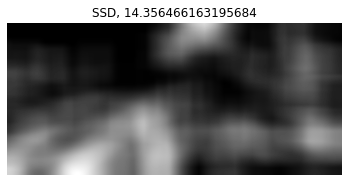

In [35]:
plt.imshow(d_SSD, cmap='gray')  
plt.title('SSD, {}'.format(rms_error(d_SSD,imgTruth)))
plt.axis('off')
plt.show()

In [28]:
d_SSD.mean()

21.983790061658716

In [20]:
d_ZSAD.mean()

30.56251161925665

In [21]:
imgTruth.mean()

6.833473325766175

In [30]:

print("res_SAD: ", np.mean(res_SAD), np.std(res_SAD))
print("res_ZSAD: ", np.mean(res_ZSAD), np.std(res_ZSAD))
print("res_SSD: ", np.mean(res_SSD), np.std(res_SSD))
print("res_ZSSD: ", np.mean(res_ZSSD), np.std(res_ZSSD))
print("res_NCC: ", np.mean(res_NCC), np.std(res_NCC))
print("res_ZNCC: ", np.mean(res_ZNCC), np.std(res_ZNCC))

print("frac_4_SAD: ", np.mean(frac_4_SAD), np.std(frac_4_SAD))
print("frac_4_ZSAD: ", np.mean(frac_4_ZSAD), np.std(frac_4_ZSAD))
print("frac_4_SSD: ", np.mean(frac_4_SSD), np.std(frac_4_SSD))
print("frac_4_ZSSD: ", np.mean(frac_4_ZSSD), np.std(frac_4_ZSSD))
print("frac_4_NCC: ", np.mean(frac_4_NCC), np.std(frac_4_NCC))
print("frac_4_ZNCC: ", np.mean(frac_4_ZNCC), np.std(frac_4_ZNCC))


print("frac_2_SAD: ", np.mean(frac_2_SAD), np.std(frac_2_SAD))
print("frac_2_ZSAD: ", np.mean(frac_2_ZSAD), np.std(frac_2_ZSAD))
print("frac_2_SSD: ", np.mean(frac_2_SSD), np.std(frac_2_SSD))
print("frac_2_ZSSD: ", np.mean(frac_2_ZSSD), np.std(frac_2_ZSSD))
print("frac_2_NCC: ", np.mean(frac_2_NCC), np.std(frac_2_NCC))
print("frac_2_ZNCC: ", np.mean(frac_2_ZNCC), np.std(frac_2_ZNCC))


print("frac_1_SAD: ", np.mean(frac_1_SAD), np.std(frac_1_SAD))
print("frac_1_ZSAD: ", np.mean(frac_1_ZSAD), np.std(frac_1_ZSAD))
print("frac_1_SSD: ", np.mean(frac_1_SSD), np.std(frac_1_SSD))
print("frac_1_ZSSD: ", np.mean(frac_1_ZSSD), np.std(frac_1_ZSSD))
print("frac_1_NCC: ", np.mean(frac_1_NCC), np.std(frac_1_NCC))
print("frac_1_ZNCC: ", np.mean(frac_1_ZNCC), np.std(frac_1_ZNCC))

print("frac_0_5_SAD: ", np.mean(frac_0_5_SAD), np.std(frac_0_5_SAD))
print("frac_0_5_ZSAD: ", np.mean(frac_0_5_ZSAD), np.std(frac_0_5_ZSAD))
print("frac_0_5_SSD: ", np.mean(frac_0_5_SSD), np.std(frac_0_5_SSD))
print("frac_0_5_ZSSD: ", np.mean(frac_0_5_ZSSD), np.std(frac_0_5_ZSSD))
print("frac_0_5_NCC: ", np.mean(frac_0_5_NCC), np.std(frac_0_5_NCC))
print("frac_0_5_ZNCC: ", np.mean(frac_0_5_ZNCC), np.std(frac_0_5_ZNCC))

print("frac_0_25_SAD: ", np.mean(frac_0_25_SAD), np.std(frac_0_25_SAD))
print("frac_0_25_ZSAD: ", np.mean(frac_0_25_ZSAD), np.std(frac_0_25_ZSAD))
print("frac_0_25_SSD: ", np.mean(frac_0_25_SSD), np.std(frac_0_25_SSD))
print("frac_0_25_ZSSD: ", np.mean(frac_0_25_ZSSD), np.std(frac_0_25_ZSSD))
print("frac_0_25_NCC: ", np.mean(frac_0_25_NCC), np.std(frac_0_25_NCC))
print("frac_0_25_ZNCC: ", np.mean(frac_0_25_ZNCC), np.std(frac_0_25_ZNCC))

print("time_SAD: ", np.mean(time_SAD), np.std(time_SAD))
print("time_ZSAD: ", np.mean(time_ZSAD), np.std(time_ZSAD))
print("time_SSD: ", np.mean(time_SSD), np.std(time_SSD))
print("time_ZSSD: ", np.mean(time_ZSSD), np.std(time_ZSSD))
print("time_NCC: ", np.mean(time_NCC), np.std(time_NCC))
print("time_ZNCC: ", np.mean(time_ZNCC), np.std(time_ZNCC))

res_SAD:  18.357435614145384 2.571022679791301
res_ZSAD:  17.534170212077616 0.8966088184662847
res_SSD:  18.07419125750634 1.945097706126306
res_ZSSD:  14.86862967143945 1.7390256362415732
res_NCC:  18.772727971072715 2.4065625728343463
res_ZNCC:  17.792982103310244 2.22644114961446
frac_4_SAD:  0.21431793262412144 0.06596945357918681
frac_4_ZSAD:  0.17337658420080776 0.03543281687781854
frac_4_SSD:  0.2248368380214265 0.04521351088250687
frac_4_ZSSD:  0.2062395255066561 0.05129900672702807
frac_4_NCC:  0.14157709057408413 0.05969654417701867
frac_4_ZNCC:  0.15551444657936725 0.053000716179224985
frac_2_SAD:  0.10175998780180877 0.03205806175489665
frac_2_ZSAD:  0.08328991265033961 0.019584667577832525
frac_2_SSD:  0.11229137018880804 0.025169376899926738
frac_2_ZSSD:  0.09964611842521703 0.030584981959827885
frac_2_NCC:  0.07130859395313756 0.03358026868334114
frac_2_ZNCC:  0.07522897211075266 0.026030967160407117
frac_1_SAD:  0.05012491053252954 0.015613710280911786
frac_1_ZSAD:  0.

# 4. Plot images without smoothing the result

In [31]:
# Some plots of images and the direct result without the smooth
import time
start_time = time.time()

k = 5

d1 = fastLocalStereo("SAD", imgL, imgR, (k,k),False, False)
d2 = fastLocalStereo("SAD", imgL, imgR, (k,k),False, True)
d3 = fastLocalStereo("SAD", imgL, imgR, (k,k), True, False)
d4 = fastLocalStereo("SAD", imgL, imgR, (k,k), True, True)

d5 = fastLocalStereo("SSD", imgL, imgR, (k,k), False, False)
d6 = fastLocalStereo("SSD", imgL, imgR, (k,k), False, True)
d7 = fastLocalStereo("SSD", imgL, imgR, (k,k), True, False)
d8 = fastLocalStereo("SSD", imgL, imgR, (k,k), True, False)

d9 = fastLocalStereo("NCC", imgL, imgR, (k,k), False, False)
d10 = fastLocalStereo("NCC", imgL, imgR, (k,k), False, True)
d11 = fastLocalStereo("NCC", imgL, imgR, (k,k), True, False)
d12 = fastLocalStereo("NCC", imgL, imgR, (k,k), True, True)

print("--- %s seconds ---" % (time.time() - start_time))

--- 9.697702884674072 seconds ---


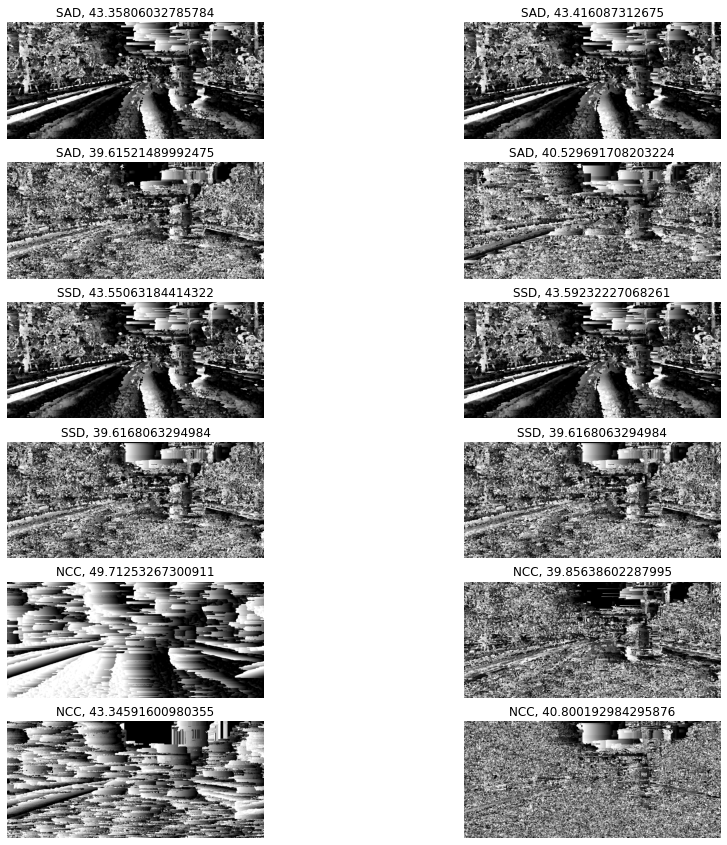

In [32]:
plt.subplots(figsize=(15, 15)) 

plt.subplot(6,2,1)
plt.imshow(d1, cmap='gray')  
plt.title('SAD, {}'.format(rms_error(d1)))
plt.axis('off')

plt.subplot(6,2,2)
plt.imshow(d2, cmap='gray')  
plt.title('SAD, {}'.format(rms_error(d2)))
plt.axis('off')

plt.subplot(6,2,3)
plt.imshow(d3, cmap='gray')  
plt.title('SAD, {}'.format(rms_error(d3)))
plt.axis('off')

plt.subplot(6,2,4)
plt.imshow(d4, cmap='gray')  
plt.title('SAD, {}'.format(rms_error(d4)))
plt.axis('off')

plt.subplot(6,2,5)
plt.imshow(d5, cmap='gray')  
plt.title('SSD, {}'.format(rms_error(d5)))
plt.axis('off')

plt.subplot(6,2,6)
plt.imshow(d6, cmap='gray')  
plt.title('SSD, {}'.format(rms_error(d6)))
plt.axis('off')

plt.subplot(6,2,7)
plt.imshow(d7, cmap='gray')  
plt.title('SSD, {}'.format(rms_error(d7)))
plt.axis('off')

plt.subplot(6,2,8)
plt.imshow(d8, cmap='gray')  
plt.title('SSD, {}'.format(rms_error(d8)))
plt.axis('off')

plt.subplot(6,2,9)
plt.imshow(d9, cmap='gray')  
plt.title('NCC, {}'.format(rms_error(d9)))
plt.axis('off')

plt.subplot(6,2,10)
plt.imshow(d10, cmap='gray')  
plt.title('NCC, {}'.format(rms_error(d10)))
plt.axis('off')

plt.subplot(6,2,11)
plt.imshow(d11, cmap='gray')  
plt.title('NCC, {}'.format(rms_error(d11)))
plt.axis('off')

plt.subplot(6,2,12)
plt.imshow(d12, cmap='gray')  
plt.title('NCC, {}'.format(rms_error(d12)))
plt.axis('off')

plt.show()
